# Section 4: Challenges and Future Directions

### The background

Biased and noisy training datasets are prevalent and impose challenges for learning. The biases and noise can happen both at the sampling and label collection stages: 

* A dataset often contains numerous sub-populations and the size of these sub-populations tends to be **long-tailed distributed**, where the tail sub-populations have an exponentially scaled probability of being under-sampled. 

* A dataset tends to suffer from **noisy labels** if collected from unverified sources.

What if both issues appear in the same dataset?

## 1. Detecting long-tail (rare) samples in a dataset

The first challenge is detecting long-tail (rare) samples in a dataset.

### 1.1 What are long-tail samples?

A dataset often contains numerous sub-populations and the size of these sub-populations tends to be long-tailed distributed, means the tail sub-populations have an exponentially scaled probability of being under-sampled. 

A figure below illustrates what are high-frequency features and long-tailed features. 

Long-tailed features appear to have a low-frequency in the data and tend to be under-fitted by the deep neural nets. Hence, bad performed.

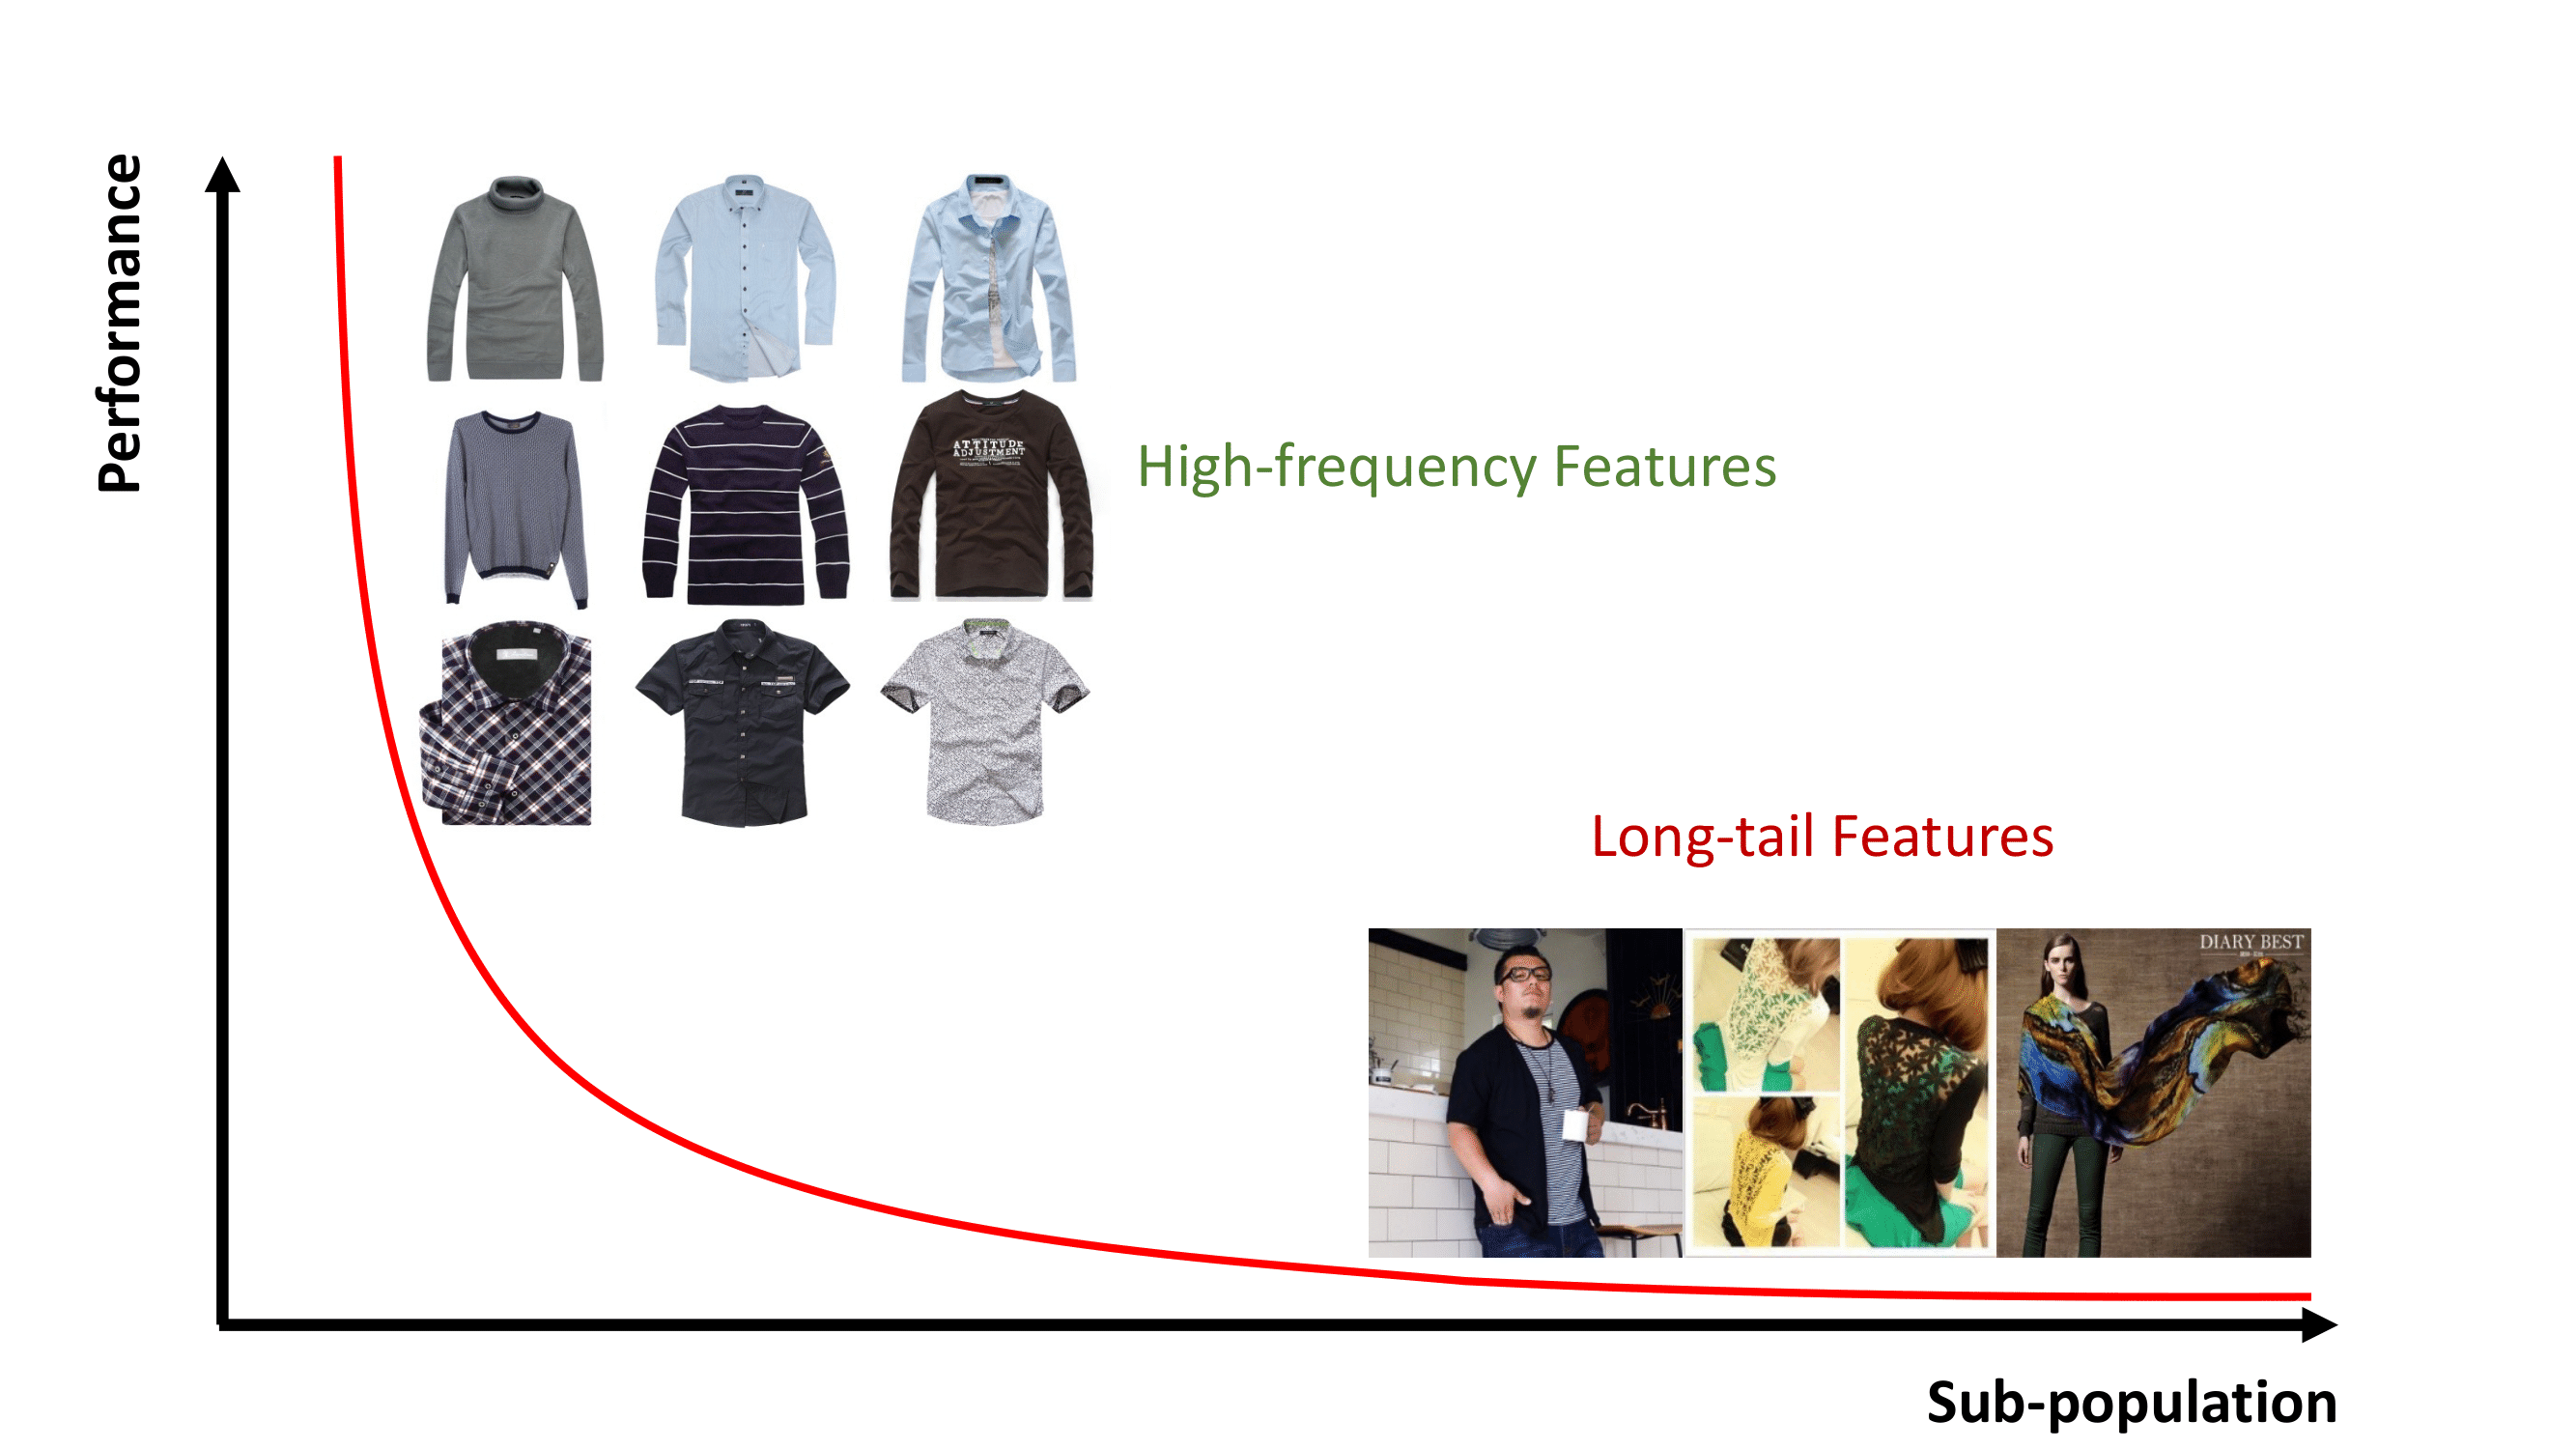

In [1]:
import sys
import os
from IPython.display import Image
path = 'tutorial_imgs/long-tail-sample.png'
display(Image(filename = path, width = 400, height = 200))

### 1.2 Use embeddings to detect long-tail samples (CIFAR-10)

**Basic intuition**: 

Consider the averaged distance between each sample and its $k$ nearest neighbors;

**Long-tail samples**: 

A sample with a larger distance by referring to its neighbors (embedding perspective) is likely to be a long-tail/rare sample.

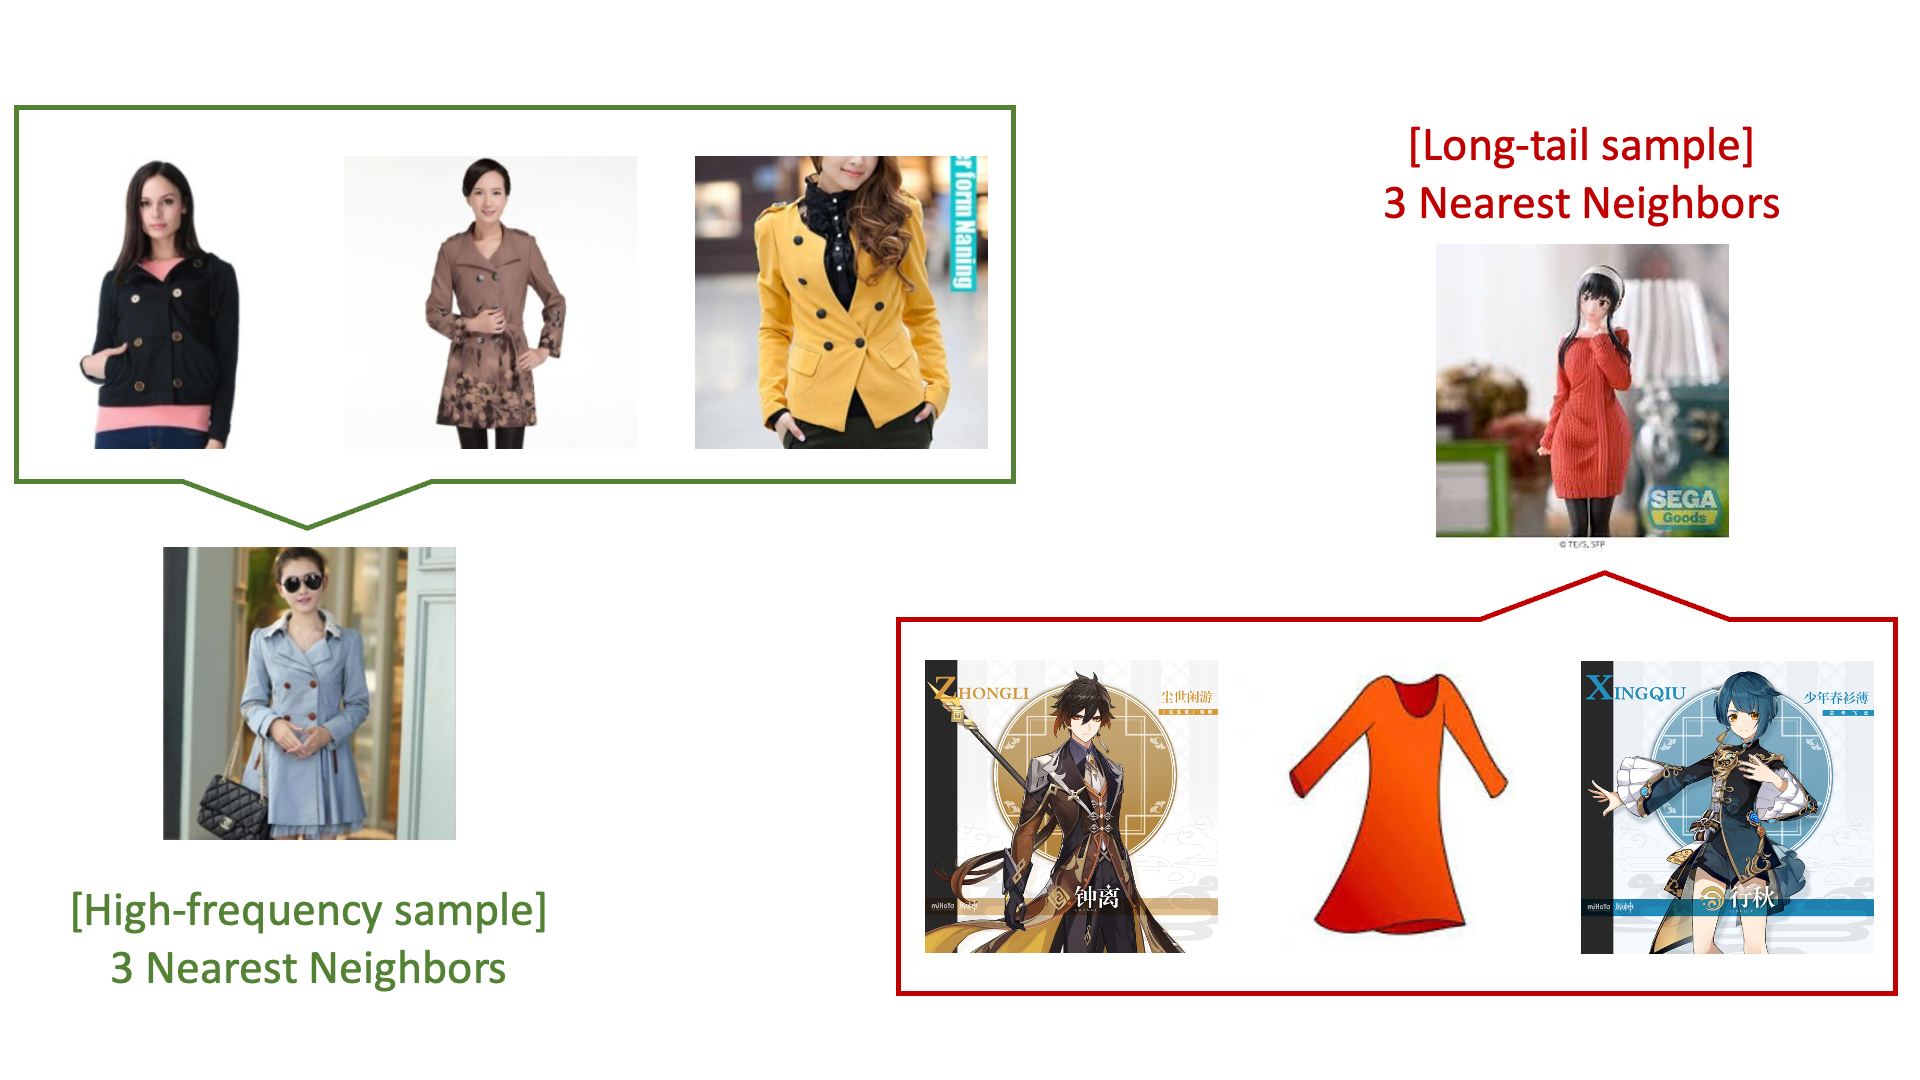

In [2]:
display(Image(filename = 'tutorial_imgs/motivation.png', width = 600, height = 300))

**Pros**: 

* General: works for any data that could be extraced as embeddings! 

* Fast: get embeddings and produce long-tail scores fast!

* Insight: embeddings are key and poopular components for depicting data samples!

In [3]:
# ! git clone https://github.com/Docta-ai/docta.git

In [4]:
os.chdir('./docta')

In [5]:
# Please consider build up a virtual enviroment when installing required packages
# ! pip3 install -r requirements.txt  

**Step 1** get long-tailed scores with pre-defined configs.

In [6]:
%run ./tools/docta_rare_pattern.py --feature_type 'embedding'

==== Docta: Doctor for your data. Current version: 0.2 ====


100%|██████████| 170498071/170498071 [00:06<00:00, 24706348.68it/s]


Extracting ./data/cifar/cifar-10-python.tar.gz to ./data/cifar/


49it [05:59,  7.34s/it]


Save 49 instances to ./results/CIFAR_c10/embedded_CIFAR_c10_0.pt
[0, 1]
idx range for training data [0]
#Samples (dataset-train) 50000.
Customizing the extracted embeddings as a dataset...
Getting consensus patterns...
Long-tail score saved to ./results/CIFAR_c10/embedding.csv


**Step2** Take a look at the long-tail scores and samples

In [7]:
import pandas as pd
lt_score_embedd = pd.read_csv('./results/CIFAR_c10/embedding.csv')
lt_score_embedd.head()

,idx,longtail_scores
0,0,0.0700
1,1,0.0683
2,2,0.0916
3,3,0.0654
4,4,0.0658


### 1.3 Visualization of long-tail images (top 20 among 50K)

In [8]:
# A help function for visualization
# %matplotlib notebook
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
def visualize_lt(idxs, data, labels, label_name):
    plt.rcParams["figure.figsize"] = (10,8)
    size = len(idxs)
    width = int(size / 5)
    for i in range(size):
        ax = plt.subplot(width,5,i+1)
        idx = idxs[i]
        ax.imshow(data.feature[idx])
        ax.set_title(f"{label_name[labels[idx]]}")
        ax.axis('off')
    plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Files already downloaded and verified


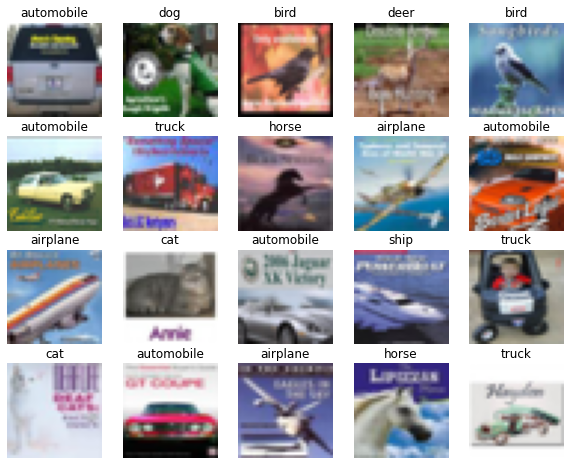

In [9]:

dataset = Cifar10_clean(cfg, train=True)
clean_label = dataset.label
feature = dataset.feature 
label_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_show = 20 # show 20 pics
lt_score = lt_score_embedd['longtail_scores'].tolist()
topN = sorted(range(len(lt_score)), key = lambda sub: lt_score[sub])[-num_show:]
visualize_lt(idxs=topN, data=dataset, labels=clean_label, label_name=label_name)

In [10]:
print(f"Indexes of {len(topN)} samples with highest long-tail scores are {topN}")

Indexes of 20 samples with highest long-tail scores are [39275, 22848, 42601, 12331, 46389, 16412, 30936, 8619, 49656, 47362, 35658, 41159, 137, 46015, 48151, 21510, 21976, 31284, 9079, 38848]


### 1.4 Visualization of head images (top 20 among 50K)

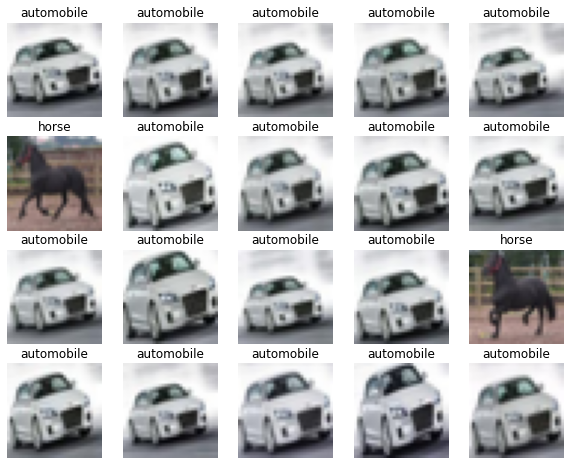

In [11]:
lastN = sorted(range(len(lt_score)), key = lambda sub: lt_score[sub])[:num_show]
visualize_lt(idxs=lastN, data=dataset, labels=clean_label, label_name=label_name)

In [12]:
print(f"Indexes of {len(lastN)} samples with lowest long-tail scores are {lastN}")

Indexes of 20 samples with lowest long-tail scores are [22479, 33063, 5834, 48612, 119, 46988, 15462, 18927, 42637, 30570, 29791, 44097, 14501, 14524, 44753, 27792, 20079, 49426, 21003, 26742]


### 1.5 The distribution of the per-sample long-tail scores 

<AxesSubplot:>

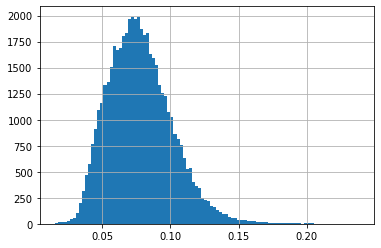

In [13]:
lt_score_embedd['longtail_scores'].hist(bins=100, figsize=[6,4])

## 2. Learning with Noisily Labeled Long-tailed Samples

### 2.1 Disparate impacts of existing solutions

**Experiment design:**

* We adopt the CIFAR-20 dataset (20 coarse classes in CIFAR-100). Each coarse class includes 5 different sub-populations (fine classes in CIFAR-100).

* We train a Resnet-32 for a 20-class classification task. Note that we have access to the sub-population information in the test time evaluation (20*5 sub-populations), for per-class (20 classes) accuracy, we further split it into the 5 sub-population accuracy. For example, given images that belong to the coarse class (trees), we will monitor the corresponding 5 sub-populations (maple, oak, palm, pine, willow) to see how many of the images are correctly classified as the class “trees”. For the sub-plots,

* For sub-plots with “Noisy” included in the sub-caption, it indicates that the noisy label was obtained from the CIFAR-20N dataset, which contains roughly 25.6% of wrong labels.

<table>
  <tr>
    <td ><img src="tutorial_imgs/dispare-impacts.png" width="1000"> 

    Figure: How each method improves per sub-population (100 classes) test accuracy w.r.t. CE loss on CIFAR-20 dataset. 
  
</td>
  </tr>
</table> 

For each sub-figure, the $x$-axis indicates the CE accuracy. $y$-axis denotes the performance of robust/long-tailed approaches. 
    
Each dot denotes the test accuracy pair $(\text{Acc}_{\text{CE}}, \text{Acc}_{\text{Method}})$ for each sub-population. The line $y=x$ stands for the case that CE performs the same as the robust treatment on a particular sub-population.

The <font color='blue'> blue </font> (<font color='red'>red</font>) dot <font color='blue'> above </font> (<font color='red'>below</font>) the line shows the robust treatment has<font color='blue'> positive </font>(<font color='red'>negative</font>) effect on this sub-population compared with CE. In the sub-titles, "Balance" denotes the balanced training data (w.r.t. clean labels); "Imbalance" means the training dataset follows a long-tailed distribution where the ratio between max and min number of samples in the sub-populations is 100; "Clean": the labels of training samples are clean; "Noisy": 25.6\% correct labels are wrongly labeled by the human annotators.The test dataset is clean and balanced.

### 2.2 Observations

* The same robust treatment may have disparate impacts on different sub-populations.
    * e.g., different sub-populations are improved differently by losses such as the Logit-adjustment loss.


* Different robust treatments have disparate impacts on the same part of data
    * e.g., Positive Label Smoothing (PLS) performs badly (almost 0 accuracies) on sub-populations with low CE accuracy (<50) and improves the others, while Logit-adjustment loss (logit-adj) has a reversed effect that the high CE accuracy part (>50) is likely to be degraded. 


* Prior works fail to address the coupling effects of population imbalance and noisy labels.